**expected behaviour:**
1. scan the terrain
2. locate panel
3. drive toward (close to the) panel

**algorithm:**
1. video acquisition
2. panel highlighting
    1. terrain remotion
    2. filtering
3. roi identification
    1. contours
    1. bounding box and center
4. motion
    1. motion direction
    2. motion performance
5. panel tracking
    1. roi features
    2. features matching
    3. moved roi estimation


**to understand:**

faster/less computational expensive perform 1...4...1... or 1...5...5... ?

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import glob
# in case of deprecation warning issued
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

###################################################################################################
###################################################################################################
# SOURCE IMAGE/VIDEO STREAM ACQUISITION
#_changed in a cycle in amin program, since easier than returning current frame too

# def videoGe(sourceVideo):
#     objectVideo = cv.VideoCapture(sourceVideo)
#     if objectVideo.isOpened():
#         returnCapture, frameCapture =objectVideo.read()
#         heightFrame,widthFrame,_=frameCapture.shape
#         return frameCapture,(heightFrame,widthFrame)
#     else: objectVideo.release(); return 0

###################################################################################################
###################################################################################################
# FOREGROUND/BACKGROUND SEPARATION
def panelFy(srcImg):
    

    # histogram param, for hs(v) space
    hBins = 180
    sBins = 255
    histSize = [hBins, sBins]
    hRanges = [1, 180]
    sRanges = [1, 256]
    Ranges = hRanges + sRanges
    Channels = [0, 1]

    # histogram(cdf) comparison method
    histCompLib = (
        ("Correlation", cv.HISTCMP_CORREL, 0.2),#or  0.4
        ("Chi-Squared", cv.HISTCMP_CHISQR, 10000000),
        ("Intersection", cv.HISTCMP_INTERSECT, 0.45),
        ("Hellinger", cv.HISTCMP_BHATTACHARYYA, 0),
        ("Kullback-Leibler",cv.HISTCMP_KL_DIV, 500))

    # choosen method and comparison threshold
    _,histCompMet, histCompThr =histCompLib[0]

    ############################
    # samples folder
    samplePath='../../images/marsyard/samples/terrain/'
    # roi extraction methods   
    sampleMetLib=('library',
            'stream')
    # selected roi extraction method
    sampleMet=sampleMetLib[0]
    ##############################
    # mask's filter param and threshold value (mask is decimal)
    if sampleMet=='library':      
        sizeElMask=3
        tyElMask=cv.MORPH_RECT
        thrValMask=10#CORREL:10, CHISQR:0-20,

    elif sampleMet=='stream':
        numElMask=4
        dimRowMask=img.shape[0]//numElMask
        dimColMask=img.shape[1]//numElMask

        sizeElMask=4
        tyElMask=cv.MORPH_RECT
        thrValMask=50    
    ################################
    # source prefiltering and color
    srcImgh=cv.cvtColor(srcImg,cv.COLOR_BGR2HSV)
    
    # source histogram
    srcImghhist = cv.calcHist([srcImgh], Channels, None, histSize, Ranges, accumulate=False)
    cv.normalize(srcImghhist, srcImghhist, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
    
    # array of good samples
    niceSamples=[]
    ##may be usefull for advanced parameter passing
    # foreground mask initialization
#     foreMask=np.zeros(srcImg.shape,np.uint8)##3channel mask
    foreMask=np.zeros((srcImg.shape[0],srcImg.shape[1]),np.uint8)##mono channel mask
    # picks roi from samples library
    if sampleMet=='library':
        for tempLibImg in glob.glob(samplePath+"*.jpg"):## manages only .jpg
            # roi acquisition
            tempLibImg=cv.cvtColor(cv.imread(tempLibImg),cv.COLOR_BGR2HSV)
            # roi hist
            roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
            cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
               # roi correlation test
            if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr:
                # usefull roi saved
                niceSamples.append(tempLibImg)
                # roi mask, mask smoothing and binarization, 3 channels conversion
                bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
                cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
                _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
                # foreground mask
#                 foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))##3 channel
                foreMask=cv.bitwise_or(foreMask,thrChanMask)##mono channel mask
    # picks roi from target image itself
#     elif sampleMet=='stream':
#         # target grid division
#         for jj in range(0,srcImg.shape[0],dimRowMask):
#             for ii in range(0,srcImg.shape[1],dimColMask):
#                 # roi acquisition
#                 tempLibImg=cv.cvtColor(srcImg[jj:jj+dimRowMask,ii:ii+dimColMask],cv.COLOR_BGR2HSV)
#                 # roi histogram
#                 roihhist= cv.calcHist([tempLibImg], Channels, None, histSize, Ranges, accumulate=False)
#                 cv.normalize(roihhist, roihhist, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)
#                 # roi correlation test
#                 if cv.compareHist(srcImghhist, roihhist, histCompMet)>histCompThr:
#                     # usefull roi saved
#                     niceSamples.append(tempLibImg)
#                     # roi mask, mask smoothing and binarization, 3 channels conversion
#                     bpMask = cv.calcBackProject([srcImgh],Channels,roihhist,Ranges,1)
#                     cv.filter2D(bpMask,-1,cv.getStructuringElement(tyElMask,(sizeElMask,sizeElMask)),bpMask)
#                     _,thrChanMask = cv.threshold(bpMask,thrValMask,255,0)
#                     # inverted foreground mask
#                     foreMask=cv.bitwise_or(foreMask,cv.merge((thrChanMask,thrChanMask,thrChanMask)))

    # foreground mask
#     foreMask=cv.bitwise_not(foreMask)
    # masked source image
#     foreResImg = cv.bitwise_and(srcImg,foreMask)
    return cv.bitwise_not(foreMask)#, foreResImg

###################################################################################################
###################################################################################################
# ROI HIGHLIGHTING
def roiFy(img2roi,groundRef=[],nocount=1,nohull=1,nomask=1,norect=0,nocentr=0):
# def roiFy(img2roi=[],img2hud=[],cont2hud=[],hull2hud=[],nocount=1,nohull=1,norect=0,nocentr=0):
## second parameter: image where hud drawn
#     def closeCnt(image2close):## NOT WORKING
#         kernel = np.ones((25,25),np.uint8)#cv.getStructuringElement(cv.MORPH_RECT,(10,10)) 
#         image2close=cv.morphologyEx(image2close,cv.MORPH_CLOSE,kernel)
#         image2close=cv.morphologyEx(image2close,cv.MORPH_RECT,kernel)
#         kernel =cv.getStructuringElement(cv.MORPH_RECT,(10,10))
#         image2close=cv.dilate(image2close,kernel,iterations=2)
#         kernel = np.ones((15,15),np.uint8)
#         image2close=cv.morphologyEx(image2close,cv.MORPH_OPEN,kernel)
#         return image2close
    img2hud=img2roi.copy()
    if len(groundRef)>0 and (groundRef.shape)[2]==1:img2roi=cv.bitwise_and(img2roi,groundRef)
    # prefiltering
    #foreground=bgForeImprov(foreground)
    
    # grayscaling and binarization
    cntsImRoi = cv.cvtColor(img2roi, cv.COLOR_BGR2GRAY)
    
    # thresholding ##IMPROV
    #imgtrack = cv.threshold(bpMask,10,255,0)#, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    cntsImRoi[cntsImRoi<10]=0
    cntsImRoi[cntsImRoi>=10]=255
    
    # contours
    cntsRoi = cv.findContours(cntsImRoi, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cntsRoi = cntsRoi[0] if len(cntsRoi) == 2 else cntsRoi[1]#_susbtituible
    # closing contours (can be also image operations before extraction)
    # cntsImRoi=closeCnt(cntsImRoi)
    maxCntRoi=max(cntsRoi, key=len)
    #_maxCntRoi=max(cntsRoi, key=lambda x: cv.contourArea(x)) ##alternatively
    
    # hull(max contour) and hullmask(max)
    hullRoi=cv.convexHull(maxCntRoi)
    hullMask=cv.fillConvexPoly(np.zeros((img2roi.shape[0],img2roi.shape[1]),np.uint8),hullRoi,255)
    
    # masked foreground image
#     img2roi=cv.bitwise_and(img2roi,img2roi,mask=hullMask)
    if not nomask: img2hud=cv.bitwise_and(img2hud,img2hud,mask=hullMask)
    # RETURN ROI RECTANGLE AND ROI CENTER AND COSMETICHS
#     def roiHud(input2hud,cnt2hud):
    # draw max contour
    if not nocount:cv.drawContours(img2hud, maxCntRoi, -1,(25,205,255), 10)

    # draw convex hull
    if not nohull:cv.drawContours(img2hud, [hullRoi], -1, (255, 255, 0), 5)

    # rotated rect 
#   rRectRoi = cv.minAreaRect(maxCntRoi)
#   rBoxRoi = np.int0(cv.boxPoints(rRectRoi))
#   cv.drawContours(img2hud, [rBoxRoi], 0, (0,0,255), 8)

    # bounding rect and center
    xRHud,yRHud,widthRoi,heightRoi = cv.boundingRect(maxCntRoi)
    if not norect:cv.rectangle(img2hud, (xRHud,yRHud), (xRHud+widthRoi,yRHud+heightRoi), (255,0,255), 5)

    # rectangle center
    centerRoi=(xcRHud,ycRHud)=(xRHud+widthRoi//2, yRHud+heightRoi//2)
    if not nocentr:cv.circle(img2hud, centerRoi, 15, (0,255,0), 18)

    return img2hud,centerRoi,widthRoi,heightRoi,hullMask#,img2roi

###################################################################################################
###################################################################################################
# ROBOT MOTION SIMULATION
def moveRob():
    return 0

###################################################################################################
###################################################################################################
# PANEL TRACKING FUNCTION
def panelTra():
    return 0

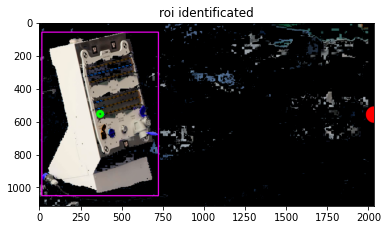

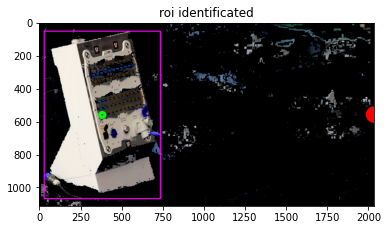

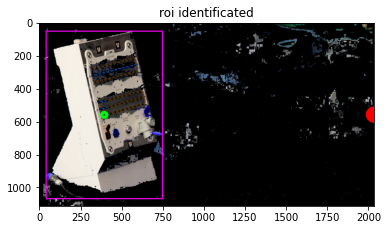

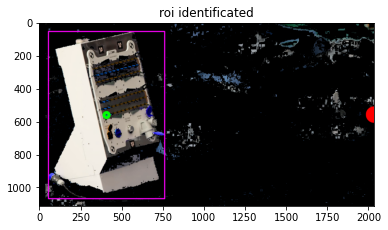

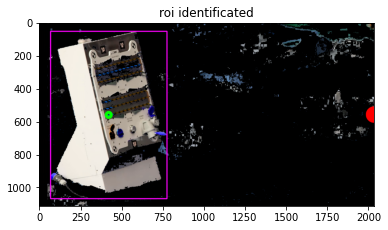

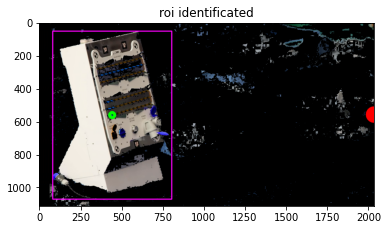

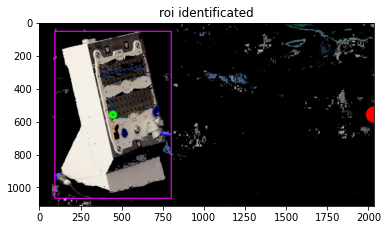

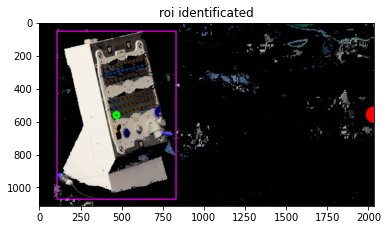

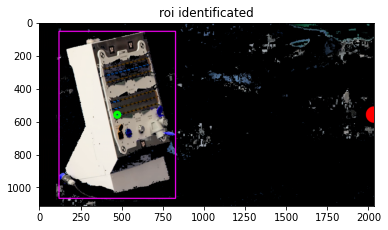

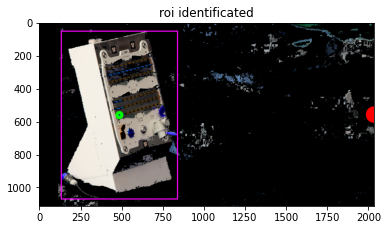

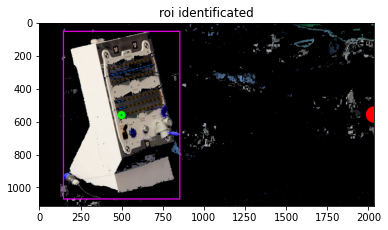

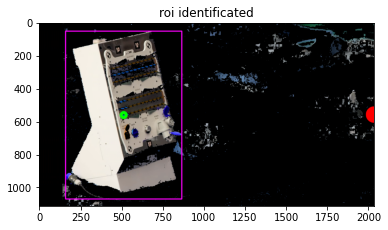

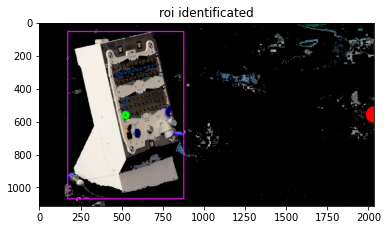

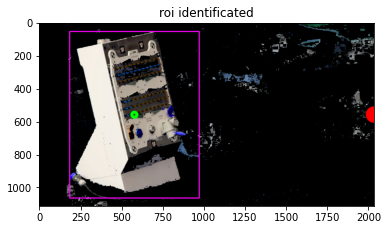

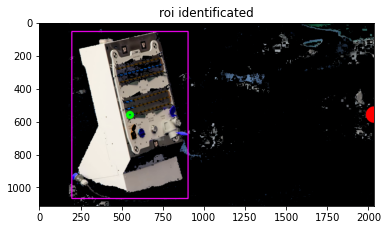

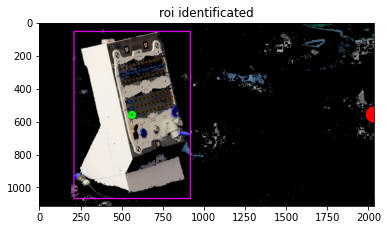

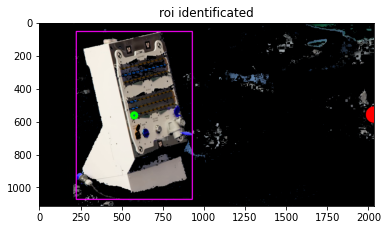

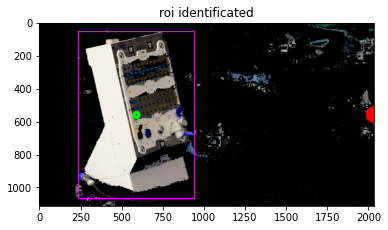

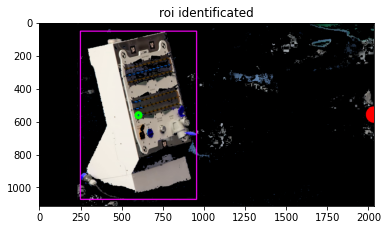

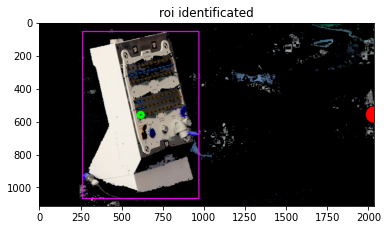

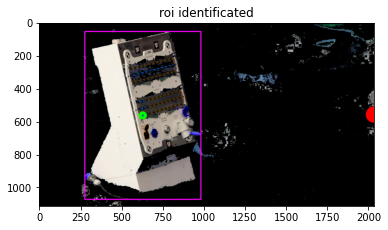

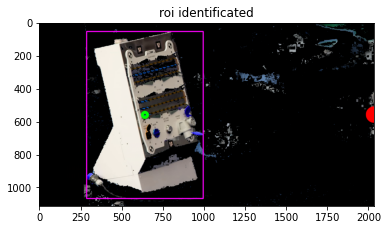

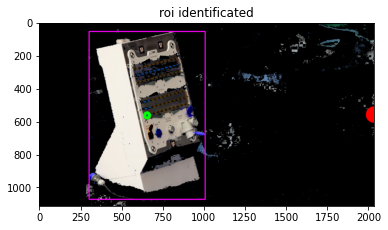

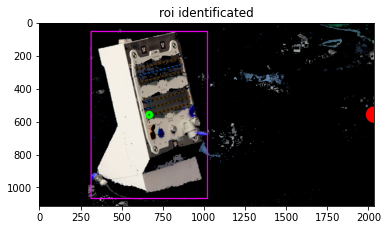

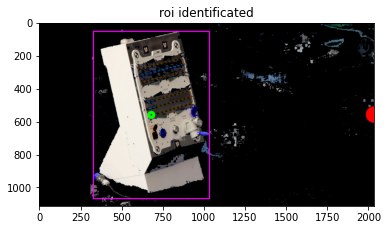

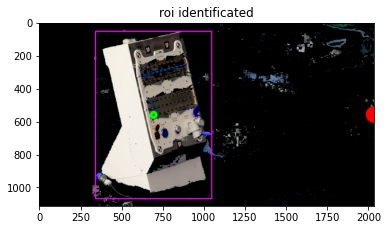

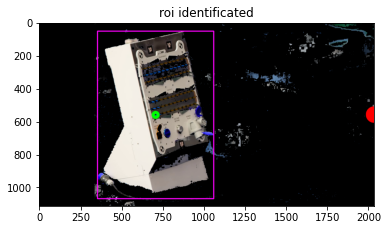

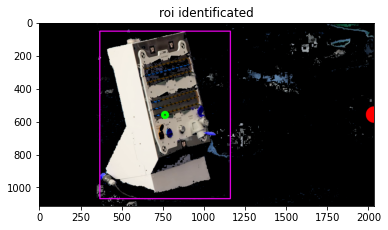

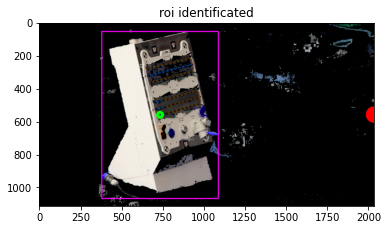

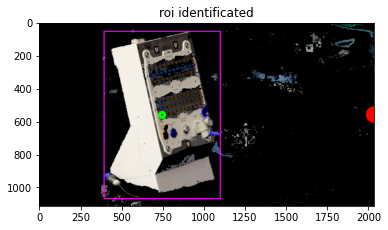

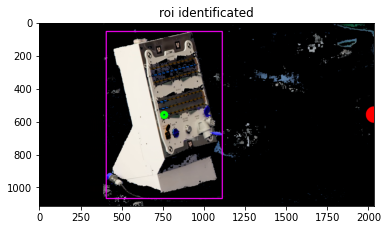

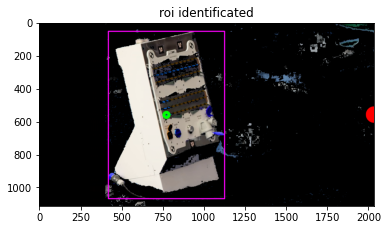

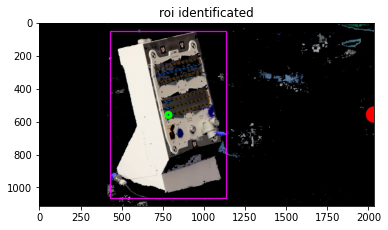

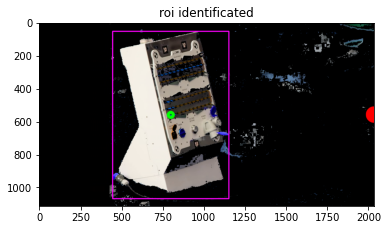

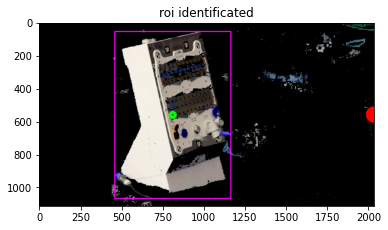

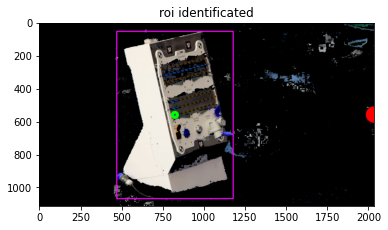

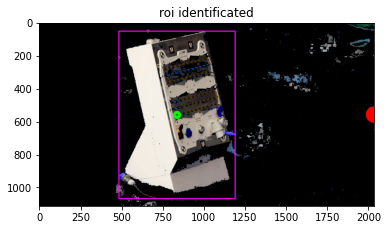

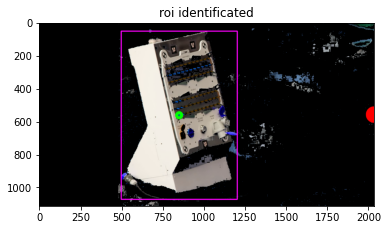

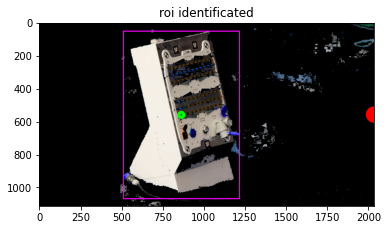

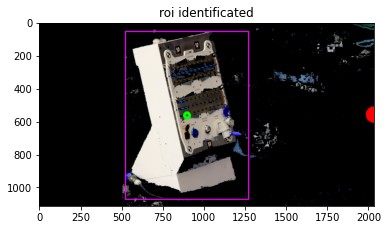

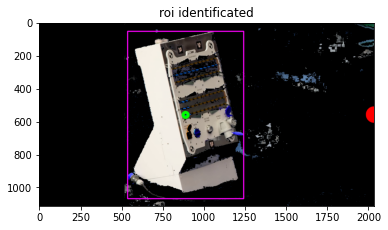

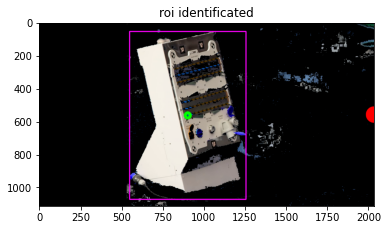

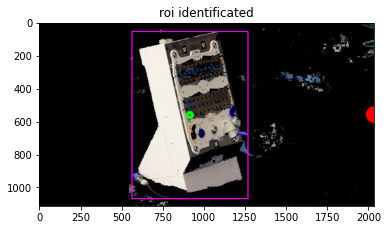

KeyboardInterrupt: 

In [2]:
#########################################
# FROM RECORDED VIDEO
#########################################
## add POV center
centMark=1

# video source
videoSrc='../../images/video/task_ext.avi'
objectVideo = cv.VideoCapture(videoSrc)

# video frame acquisition == frame
while(1):
    if objectVideo.isOpened():
        returnCapture, frameVid =objectVideo.read()
        heightFrame,widthFrame,_=frameVid.shape

    #frameVid,frameSiz=videoGe(videoSrc)
    #if centMark: cv.circle(frameVid,(widthFrame//2,heightFrame//2),50,(255),-1)
    #plt.title('input frame');plt.imshow(frameVid);plt.show()

    # frame remotion of background
    maskedImg=panelFy(frameVid)
    #if centMark: cv.circle(maskedImg,(widthFrame//2,heightFrame//2),50,(255),-1)
    #plt.title('foreground highlithed');plt.imshow(maskedImg[:,:widthFrame//2]);plt.show()

    # frame identification of panel, roi center and dimensions   
    roimage,rco,wr,hr,_=roiFy(maskedImg)
    if centMark: cv.circle(roimage,(widthFrame//2,heightFrame//2),50,(255),-1)
    plt.title('roi identificated');plt.imshow(roimage[:,:widthFrame//2]);plt.show()



In [18]:
print(panelMask.shape)

(1335, 2000, 3)


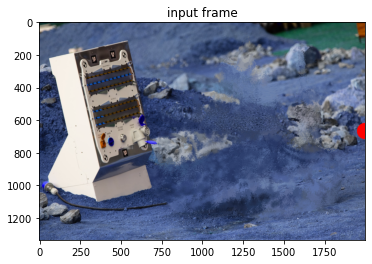

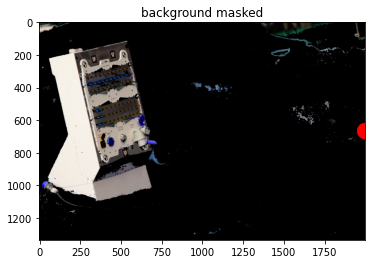

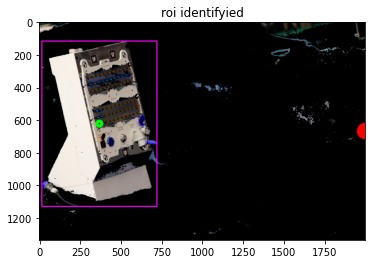

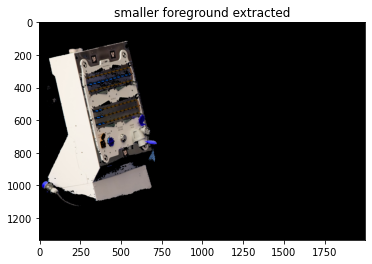

In [3]:
###########################################
# FROM IMAGE
###########################################

## add POV center
centMark=1

## image used in video making = test
frameVid=cv.imread('../../images/marsyard/taskfinal.jpg')
*frameSiz,_=frameVid.shape
if centMark: frameDis=cv.circle(frameVid.copy(),(frameSiz[1],frameSiz[0]//2),50,(255),-1)
plt.title('input frame');plt.imshow(frameDis);plt.show()

# frame remotion of background
panelMask=panelFy(frameVid)
# maskedImg=cv.bitwise_and(frameVid,panelMask)##3channel mask
maskedImg=cv.bitwise_and(frameVid,frameVid,mask=panelMask)##mono channel mask
if centMark: maskedDis=cv.circle(maskedImg.copy(),(frameSiz[1],frameSiz[0]//2),50,(255),-1)
plt.title('background masked');plt.imshow(maskedDis);plt.show()

# frame identification of panel, roi center and dimensions   
hudImg,rco,wr,hr,roiMask=roiFy(maskedImg)
if centMark: hudDis=cv.circle(hudImg.copy(),(frameSiz[1],frameSiz[0]//2),50,(255),-1)
plt.title('roi identifyied');plt.imshow(hudDis);plt.show()
plt.title('smaller foreground extracted');
plt.imshow(cv.bitwise_and(maskedImg,maskedImg,mask=roiMask));plt.show()

In [ ]:
#################################################
# FROM LIVE VIDEO STREAM
#################################################


